# Nonsmooth Analysis and Optimization

In [1250]:
import numpy as np
from scipy import sparse, linalg
from matplotlib import cm
from matplotlib import pyplot as plt

## Problem definition
We consider the minimization problem without restrictions, for the objective function
\begin{equation}
J(x) = \frac{1}{2} \| Ax - b \|^2 + \alpha \|D x \|_1
\end{equation}

In [1251]:
A = np.random.normal( 0, 5, ( 1000, 2 ) )
D = np.random.normal( 0, 3, ( 1000, 2 ) )
b = np.random.normal( 0, 2, 1000 )
# A = np.eye( 2 )
# D = np.eye( 2 )
# b = np.random.normal( 0, 2, 2 )
alpha = 0.001

def J( x ) :
    global A, b, alpha, D
    Jx = 0.5 * linalg.norm( A.dot( x ) - b )**2 + alpha * linalg.norm( D.dot( x ), 1 )
    return Jx

## Subdifferentials
The objective function $J$ can be decomposed like the sum $J = F + \alpha G$ with $F(x) = \frac{1}{2} \| Ax - b \|^2$ and $G(x) = \|Dx\|_1$.

The respective subdifferentials for function $F$ and $G$ are
\begin{equation}
\partial F(x) = \{ \nabla F(x)\} = \{ A^T ( Ax - b ) \}
\end{equation}

\begin{equation}
\partial G(x) = \partial \left( \| \cdot \|_1 \circ D \right)(x) = D^T \partial \| D x \|_1 
\end{equation}

A well know result for the subdiferential of the $l_1$-norm
\begin{equation}
\partial \| x \|_1
= \sum\limits_{i=1}^n sign( x_i ) \mathbf{1}_{\mathbb{R} \setminus \{0\}}( x_i )  e_i + \mathbf{1}_{\{0\}}( x_i ) [-e_i, e_i ]
\end{equation}

In [1252]:
K = A.T.dot( A )
c = A.T.dot( b )

def dJ( x ) :
    global K, c, alpha, D
    g = K.dot( x ) - c + alpha * D.T.dot( np.sign( D.dot( x ) ) )   
    return g

## Proximal mapping
\begin{equation}
prox_{\tau J}( x ) = \underset{y \in \mathbb{R}^n}{\arg\min} \frac{1}{2} \| y - x \|^2 + \tau J( y )
\end{equation}

Proximal mapping for the $F$ function
\begin{equation}
prox_{\tau F}(x) = \left( I + \tau A^T A \right)^{-1}\left( x - \tau A^T b \right)
\end{equation}

Proximal mapping for the $G$ function. It is important to recall
\begin{equation}
G(x) = \|Dx\|_1 = \sum\limits_{i=1}^n | d_i^T x |
\end{equation}

Approximation of the proximal map of $\tau_k J$
\begin{eqnarray*}
prox_{\tau_k J} 
& \approx & prox_{\tau_k F} \circ prox_{\tau_k G} \\
& \approx & prox_{\tau_k F} \circ prox_{\tau_k | d_1^T \cdot |} \circ \cdots \circ prox_{\tau_k | d_n^T \cdot |}
\end{eqnarray*}
where for each function $\tau | d^T \cdot |$
\begin{equation}
prox_{\tau | d^T \cdot |}(x)
= x + \frac{\tau}{\|\tau d\|^2} \left( \left( | \tau d^T | - \tau^2 \|d\|^2 \right)_+ sign\left( \tau d^T x \right) - \tau d^T x \right) d
\end{equation}

In [1253]:
def prox_abs_1( x, tau ) :
  y = 0
  if x >= tau :
      y = x - tau
  elif x <= -tau:
      y = x + tau

  return y

def prox_norm_1_scalar( d, x, tau ) :
  nd = linalg.norm( d )**2
  p = x + ( tau / ( ( tau * nd )**2 ) ) * ( prox_abs_1( tau * d.dot( x ), ( tau * nd )**2 ) - tau * d.dot( x ) ) * d
  return p


--- 
## Subgradient descent 
The algorithm is mainly given by the iteration
\begin{eqnarray*}
x^{k+1} & \in & x^k - \tau_k \partial J( x^k ) \\
& \in & x^k - \tau_k \partial F( x^k ) - \tau_k \partial G( x^k ) \\
& \in & x^k - \tau_k A^T ( Ax^k - b ) - \tau_k D^T \partial \| D x^k \|_1
\end{eqnarray*}

In [1254]:
def subgradient_descent( x, tau, J, dJ, e, N ) :
  n = x.size
  k = 0
  ng = 2 * e 
  
  G = []
  F = []
  while k < N and ng > e:
    g = dJ( x )
    x = x - tau * g
    
    ng = linalg.norm( g )
    G.append( ng )
    F.append( J( x ) )
    k = k + 1

  return [ x, g, ng, F, G, k ]

In [1255]:
e = 1e-12
N = 1000
tau = 0.00001
x = np.random.normal( 0, 1, 2 )

x, g, ng, F, G, k = subgradient_descent( x, tau, J, dJ, e, N )

print( k )
print( g )
print( ng )

print( x )
# print( b )
print( F[ k - 1 ] )

144
[ 8.86846152e-13 -1.63091762e-13]
9.017178163805971e-13
[ 0.00804685 -0.00305638]
1985.5886997751502


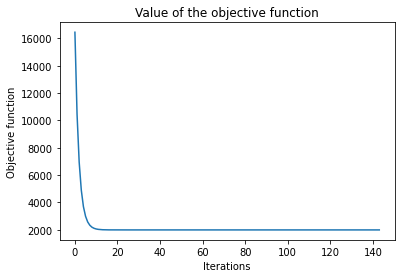

In [1256]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Objective function' )
plt.title( 'Value of the objective function' )
plt.plot( F )

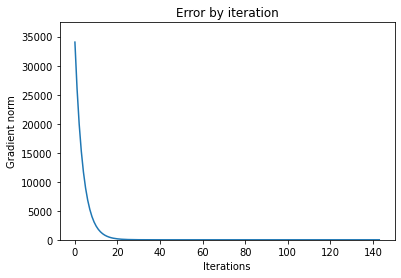

In [1257]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Gradient norm' )
plt.title( 'Error by iteration' )
# plt.xscale( 'log' )
# plt.yscale( 'log' )
plt.ylim( (0, np.max( G ) * 1.1 ) )
plt.plot( G )

---
## Proximal point method
The algorithm is mainly given by the iteration
\begin{eqnarray*}
x^{k+1} 
& = & prox_{\tau_k J}( x^k ) \\
& \approx & prox_{\tau_k F} \circ prox_{\tau_k | d_1^T \cdot |} \circ \cdots \circ prox_{\tau_k | d_n^T \cdot |} ( x^k )
\end{eqnarray*}

In [1258]:
def proximal_point_method( x, tau, J, dJ, e, N ) :
  n = x.size
  m = D.shape[0]
  k = 0
  ng = 2 * e 
  
  G = []
  F = []
  while k < N and ng > e:
    x = np.linalg.solve( np.identity( n ) + tau * K, x - tau * c )
    for i in range( 0, m ) :
      x = prox_norm_1_scalar( D[i,], x, tau * alpha )
    
    g = dJ( -x )
    ng = linalg.norm( g )
    G.append( ng )
    F.append( J( -x ) )
    k = k + 1
  
  x = -x
  return [ x, g, ng, F, G, k ]

In [1259]:
e = 1e-12
N = 100
tau = 0.0001
x = np.random.normal( 0, 1, 2 )

x, g, ng, F, G, k = proximal_point_method( x, tau, J, dJ, e, N )

print( k )
print( g )
print( ng )

print( x )
# print( b )
print( F[ k - 1 ] )

100
[-5.08453068  2.02527144]
5.473040892831425
[ 0.00782955 -0.00297162]
1985.5893380260686


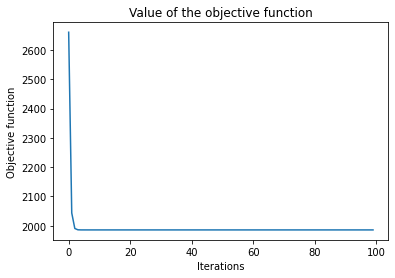

In [1260]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Objective function' )
plt.title( 'Value of the objective function' )
plt.plot( F )

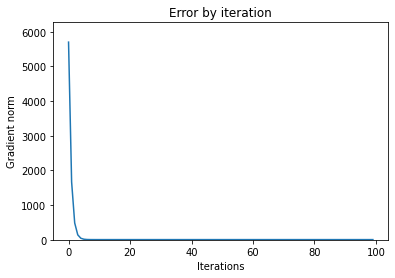

In [1261]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Gradient norm' )
plt.title( 'Error by iteration' )
# plt.xscale( 'log' )
# plt.yscale( 'log' )
plt.ylim( (0, np.max( G ) * 1.1 ) )
plt.plot( G )

---
## Forward-Backward splitting
The algorithm is mainly given by the iteration
\begin{eqnarray*}
x^{k+1} & = & prox_{\tau_k G}\left( x^k - \tau_k \nabla F( x^k ) \right) \\
& = & prox_{\tau_k G}\left( x^k - \tau_k A^T( Ax^k - b ) \right) \\
& \approx & prox_{\tau_k | d_1^T \cdot |} \circ \cdots \circ prox_{\tau_k | d_n^T \cdot |} \left( x^k - \tau_k A^T( Ax^k - b ) \right) 
\end{eqnarray*}

In [1262]:
def forward_backward_split( x, tau, J, dJ, e, N ) :
  m = D.shape[0]
  k = 0
  ng = 2 * e 
  
  G = []
  F = []
  while k < N and ng > e:
    
    p = A.T.dot( A.dot( x ) - b )
    x = x - tau * p
    for i in range( 0, m ) :
      x = prox_norm_1_scalar( D[i,], x, tau * alpha )
    
    g = dJ( x )
    ng = linalg.norm( g )
    G.append( ng )
    F.append( J( x ) )
    k = k + 1
    
  return [ x, g, ng, F, G, k ]

In [1264]:
e = 1e-12
N = 100
tau = 0.00001
x = np.random.normal( 0, 1, 2 )

x, g, ng, F, G, k = forward_backward_split( x, tau, J, dJ, e, N )

print( k )
print( g )
print( ng )

print( x )
# print( b )
print( F[ k - 1 ] )

100
[-8.09448522e-08  7.58471008e-09]
8.129942753380769e-08
[ 0.00804685 -0.00305638]
1985.5886997751497


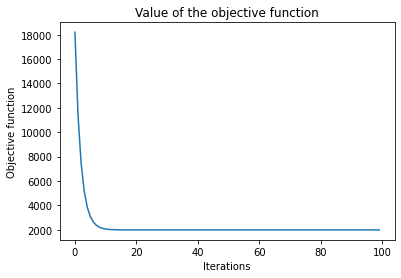

In [1265]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Objective function' )
plt.title( 'Value of the objective function' )
plt.plot( F )

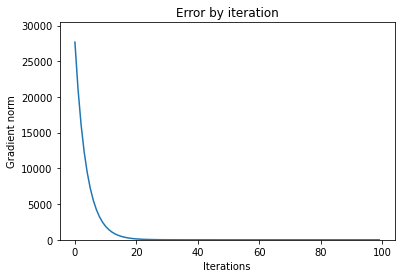

In [1266]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Gradient norm' )
plt.title( 'Error by iteration' )
# plt.xscale( 'log' )
# plt.yscale( 'log' )
plt.ylim( (0, np.max( G ) * 1.1 ) )
plt.plot( G )